In [1]:
import numpy as np
import neuron
from neuron import h
import os, sys
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PolyCollection
import subprocess
import pickle, glob
from scipy.signal import chirp 
from scipy.fftpack import fft
from scipy.optimize import leastsq, curve_fit
import re
import scipy.signal
from scipy.signal import find_peaks
from operator import itemgetter
import os, subprocess
import numba
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score

def svg_to_emf(svg_figpath):
    if True:
        cwd_path = os.getcwd()
        svg_figpath = os.path.join(cwd_path, svg_figpath)
        print(svg_figpath)
    inkscape_path = 'D:\\Pycharm\\Inkscape\\bin\\inkscape.exe' 
    if svg_figpath is not None:
        path, svgfigname = os.path.split(svg_figpath)
        figname, figform = os.path.splitext(svgfigname)
        emf_figpath = os.path.join(path, figname + '.emf')
        subprocess.call("{} {} -T -o {}".format(inkscape_path, svg_figpath, emf_figpath), shell=True)
        # os.remove(svg_figpath)

'''generate EPSP-like synaptic current'''
def generate_epsp_like_current(taur=0.5, taud=5, imax=0.5, onset=320, dt=0.025, tstop=600):
    iepsp = np.zeros(int(tstop/dt))
    tpeak = taur * taud * np.log(taur/taud) / (taur-taud)
    adjust = 1/( (1 - myexp(-tpeak/taur)) - (1 - myexp(-tpeak/taud)) )
    amp = adjust * imax
    for i, t in enumerate(np.arange(0, tstop, dt)):
        if t < onset:
            iepsp[i] = 0.
        else:
            a0 = 1 - myexp(-(t-onset)/taur)
            a1 = 1 - myexp(-(t-onset)/taud)
            iepsp[i] = -amp * (a0 - a1)
    return iepsp

def myexp(x):
    if x < -100:
        return 0
    else:
        return np.exp(x)

def generateOUCurrent(miu=0., sigma=0., tvar=np.arange(0, 10, 0.1)):
    tau = 3
    dt = tvar[1] - tvar[0]
    Istim = np.zeros_like(tvar)
    Istim[0] = miu
    for i in range(len(tvar)-1):
        Istim[i+1] = Istim[i] + dt*(miu - Istim[i])/tau + sigma*np.random.randn()*np.sqrt(2*dt/tau)
    return Istim

def calcSpikeNumberAndSpikeTime(tvar, vsoma):
    risingBefore = np.hstack((0, vsoma[1:] - vsoma[:-1])) > 0  # v(t)-v(t-1)>0
    fallingAfter = np.hstack((vsoma[1:] - vsoma[:-1], 0)) < 0  # v(t)-v(t+1)<0
    localMaximum = np.logical_and(fallingAfter, risingBefore) 
    largerThanThresh = vsoma > 0. 
    binarySpikeVector = np.logical_and(localMaximum,largerThanThresh) 
    spikeInds = np.nonzero(binarySpikeVector)
    spikeNumber = np.sum(binarySpikeVector)
    outputSpikeTimes = tvar[spikeInds]
    return spikeNumber, outputSpikeTimes

@numba.njit
def generatePulseCurrent(amp_pulse=0., tstart=0., tend=0., tvar=np.arange(0, 1, 0.01)):
    index_pulse = np.logical_and(tvar >= tstart, tvar <= tend)
    Ipulse = np.zeros_like(tvar)
    Ipulse[index_pulse] = amp_pulse
    return Ipulse
    
@numba.njit
def isCalciumSpike(tvar, vdend, CaSpike_startVth=-30, CaSpike_endVth=-50):
    logical_above_startVth = vdend > CaSpike_startVth
    logical_above_endVth   = vdend > CaSpike_endVth
    diff_logical_above_startVth = np.diff(logical_above_startVth)
    diff_logical_above_endVth   = np.diff(logical_above_endVth)
    bool, CaSpike_start_t, CaSpike_end_t = 0, None, None
    if np.any(diff_logical_above_startVth):
        bool = 1
        CaSpike_start_t = tvar[np.where(diff_logical_above_startVth)][0]
        CaSpike_end_t   = tvar[:-1][np.where(diff_logical_above_endVth)][-1]
    return bool, CaSpike_start_t, CaSpike_end_t
    
@numba.njit
def calcICaTime(tvar, ICa, ICaVth=-0.12):
    index_below_ICaVth = ICa < ICaVth
    diff_index_below_ICaVth = np.diff(index_below_ICaVth)
    bool, ICa_start_t, ICa_end_t = 0, None, None
    if np.any(diff_index_below_ICaVth):
        bool        = 1
        ICa_start_t = tvar[np.where(diff_index_below_ICaVth)][0]
        ICa_end_t   = tvar[np.where(diff_index_below_ICaVth)][1]
    return bool, ICa_start_t, ICa_end_t
    
def Sort_by_col1(paras):
    num_paras   = len(paras)
    xtemp       = sorted(enumerate(paras[0]), key=itemgetter(1))
    xindex      = map(itemgetter(0), xtemp)
    multi_piker = itemgetter(*xindex)
    ans         = np.array([multi_piker(paras[i]) for i in range(num_paras)])
    return ans

def thresholdLinearFunction(x, b, k):
    y = np.piecewise(x, [x<b, x>=b], [0., lambda x: k*(x-b)])
    return y

In [2]:
class L5PTcell():
    def __init__(self):
        self.init_parameters()
        self.create_cell()
        self.createSectionList()

    def init_parameters(self):
        self.diam_scale_factor = 0    
        self.diam_plus_factor  = 2     
        self.subsection_names  = ['soma',  'apic', 'dend', 'axon']
        self.subsection_colors = [   'k',     'b',    'g',    'r']
        self.eachSubsectionIndex = []  
        self.eachSubsectionIndex.append([0, 1])
        self.eachSubsectionIndex.append([1, 80])
        self.eachSubsectionIndex.append([80, 130])
        self.eachSubsectionIndex.append([130, 142])
        self.somaAtOrigin      = False
        self.shiftx, self.shifty, self.shiftz = 0.0, 0.0, 0.0
        
    def create_cell(self):
        h.load_file('nrngui.hoc')
        h.load_file('init_snowp.hoc')
        h.load_file("steadystate_init.hoc")
        h.load_file("getes.hoc")
        
    def createSectionList(self):
        self.allSectionList    = [sec for sec in h.allsec()]
        self.allSectionNames   = [sec.name() for sec in self.allSectionList]
        self.totalSectionNumber= len(self.allSectionList)
        self.somaSectionList   = self.allSectionList[self.eachSubsectionIndex[0][0]:self.eachSubsectionIndex[0][1]]
        self.apicalSectionList = self.allSectionList[self.eachSubsectionIndex[1][0]:self.eachSubsectionIndex[1][1]]
        self.basalSectionList  = self.allSectionList[self.eachSubsectionIndex[2][0]:self.eachSubsectionIndex[2][1]]
        self.axonalSectionList = self.allSectionList[self.eachSubsectionIndex[3][0]:]
        self.eachSectionSegmentNumber = np.array([sec.nseg for sec in self.allSectionList])
        self.totalSegmentNumber = np.sum(self.eachSectionSegmentNumber)
        self.totnsegs = self.totalSegmentNumber
        self.eachSectionSegmentIndex = []
        idx0, idx1 = 0, 0
        for i in range(self.totalSectionNumber):
            idx1 += self.eachSectionSegmentNumber[i]
            self.eachSectionSegmentIndex.append([idx0, idx1])
            idx0 = idx1
            
    def pre_calc_for_plotmorph(self, projection=('x', 'y')):
        if not hasattr(self, 'allSectionList'):
            self.createSectionList()
        self.collect_geometry()
        self.make_soma_at_origin(somaAtOrigin=self.somaAtOrigin)
        self.morph_zips = []
        for x, y in self.get_idx_polygons(projection=projection):
            self.morph_zips.append(list(zip(x, y)))

    def collect_geometry(self):
        if not hasattr(self, 'x'):
            self.x      = None
            self.y      = None
            self.z      = None
            self.area   = None
            self.d      = None
            self.length = None
        self.collect_geometry_neuron()
        
    def collect_geometry_neuron(self):
        '''Loop over allseclist to determine area, diam, xyz-start- and endpoints, embed geometry to cell object'''
        areavec   = np.zeros(self.totnsegs)
        diamvec   = np.zeros(self.totnsegs)
        lengthvec = np.zeros(self.totnsegs)
        xstartvec = np.zeros(self.totnsegs)
        xendvec   = np.zeros(self.totnsegs)
        ystartvec = np.zeros(self.totnsegs)
        yendvec   = np.zeros(self.totnsegs)
        zstartvec = np.zeros(self.totnsegs)
        zendvec   = np.zeros(self.totnsegs)
        counter = 0
        # loop over all segments
        for sec in self.allSectionList:
            n3d  = int(neuron.h.n3d(sec=sec))  # or int(sec.n3d())
            nseg = sec.nseg                    # sec.n3d() > sec.nseg
            gsen2 = 1. / 2 / nseg 
            if n3d > 0:
                # create interpolation objects for the xyz pt3d info:
                L, x, y, z = np.zeros(n3d), np.zeros(n3d), np.zeros(n3d), np.zeros(n3d)
                for i in range(n3d):
                    L[i] = neuron.h.arc3d(i, sec=sec) # return the length of the first i-th n3d()
                    x[i] = neuron.h.x3d(i, sec=sec)
                    y[i] = neuron.h.y3d(i, sec=sec)
                    z[i] = neuron.h.z3d(i, sec=sec)
                # normalize as seg.x [0, 1]
                L /= sec.L
                # temporary store position of segment midpoints
                segx = np.zeros(nseg) 
                for i, seg in enumerate(sec):
                    segx[i] = seg.x 
                # can't be >0 which may happen due to NEURON->Python float
                # transfer:
                segx0 = (segx - gsen2).round(decimals=6)
                segx1 = (segx + gsen2).round(decimals=6) 
                # fill vectors with interpolated coordinates of start and end
                # points
                xstartvec[counter:counter + nseg] = np.interp(segx0, L, x)  
                xendvec[counter:counter   + nseg] = np.interp(segx1, L, x)  
                ystartvec[counter:counter + nseg] = np.interp(segx0, L, y)
                yendvec[counter:counter   + nseg] = np.interp(segx1, L, y)
                zstartvec[counter:counter + nseg] = np.interp(segx0, L, z)
                zendvec[counter:counter   + nseg] = np.interp(segx1, L, z)
                # fill in values area, diam, length
                for seg in sec:
                    areavec[counter]   = neuron.h.area(seg.x, sec=sec)
                    diamvec[counter]   = seg.diam
                    lengthvec[counter] = sec.L / nseg
                    counter += 1
        # set cell attributes
        self.x = np.c_[xstartvec, xendvec]
        self.y = np.c_[ystartvec, yendvec]
        self.z = np.c_[zstartvec, zendvec]
        self.area   = areavec
        self.d      = diamvec * self.diam_scale_factor + self.diam_plus_factor
        self.length = lengthvec

    def make_soma_at_origin(self, somaAtOrigin=True):
        if somaAtOrigin == True:
            self.shiftx = np.mean(self.x[0])
            self.shifty = np.mean(self.y[0])
            self.shiftz = np.mean(self.z[0])
            self.x = self.x - self.shiftx
            self.y = self.y - self.shifty
            self.z = self.z - self.shiftz
        elif somaAtOrigin == False:
            self.shiftx, self.shifty, self.shiftz = 0.0, 0.0, 0.0
            
    def get_idx_polygons(self, projection=('x', 'z')):
        if len(projection) != 2:
            raise ValueError("projection arg be a tuple like ('x', 'y')")
        if 'x' in projection and 'y' in projection:
            pass
        elif 'x' in projection and 'z' in projection:
            pass
        elif 'y' in projection and 'z' in projection:
            pass
        else:
            mssg = "projection must be a length 2 tuple of 'x', 'y' or 'z'!"
            raise ValueError(mssg)

        polygons = []
        for i in np.arange(self.totnsegs):
            polygons.append(self.create_segment_polygon(i, projection))
        
        return polygons

    def create_segment_polygon(self, i, projection=('x', 'z')):
        '''Create a polygon to fill for segment i, in the plane determined by kwarg projection'''
        x = getattr(self, projection[0])[i]
        z = getattr(self, projection[1])[i]
        d = self.d[i]
        # calculate angles
        dx = np.diff(x)
        dz = np.diff(z)
        theta = np.arctan2(dz, dx)[0]
        x = np.r_[x, x[::-1]]  # x=(xstart, xend), x[::-1]=(xend, xstart) →→→ x.shape=(1, 4)
        z = np.r_[z, z[::-1]]
        # 1st corner:
        x[0] -= 0.5 * d * np.sin(theta)
        z[0] += 0.5 * d * np.cos(theta)
        # end of section, first side
        x[1] -= 0.5 * d * np.sin(theta)
        z[1] += 0.5 * d * np.cos(theta)
        # other side
        # end of section, second side
        x[2] += 0.5 * d * np.sin(theta)
        z[2] -= 0.5 * d * np.cos(theta)
        # last corner:
        x[3] += 0.5 * d * np.sin(theta)
        z[3] -= 0.5 * d * np.cos(theta)
        return x, z # x.shape=y.shape=(1, 4)

    def get_section_coordinate(self, sec, xin, projection=('x', 'y')):
        n3d   = int(neuron.h.n3d(sec=sec))
        nseg  = sec.nseg
        gsen2 = 1. / 2 / nseg
        if n3d > 0:
            L, x, y, z = np.zeros(n3d), np.zeros(n3d), np.zeros(n3d), np.zeros(n3d)
            for i in range(n3d):
                L[i] = neuron.h.arc3d(i, sec=sec)
                x[i] = neuron.h.x3d(i, sec=sec)
                y[i] = neuron.h.y3d(i, sec=sec)
                z[i] = neuron.h.z3d(i, sec=sec)
            L /= sec.L
            sec_x = np.interp(xin, L, x) - self.shiftx
            sec_y = np.interp(xin, L, y) - self.shifty
            sec_z = np.interp(xin, L, z) - self.shiftz
            coordinate = {'x': sec_x, 'y': sec_y, 'z': sec_z}
        return np.array([coordinate[projection[0]], coordinate[projection[1]]])

    def add_recordings(self, sec, x=0.5):
        if not hasattr(self, 'recordings'):
            self.recordings = {}
        if 't' not in list(self.recordings.keys()):
            self.recordings['t'] = h.Vector().record(h._ref_t)
        tempname = sec.name() + '(' + str(x) + ')'
        self.recordings[tempname] = h.Vector().record(sec(x)._ref_v)
        
    def run_simulation_EFtest(self, Evar=0., tvar=0., dt=0.025, duration=0., theta=90, phi=90):
        '''Simulation'''
        h.calcesE(theta, phi)
        h.dt = dt
        h.tstop = duration
        h.setstim_snowp()
        h.stim_amp.from_python(Evar)
        h.stim_time.from_python(tvar)
        h.attach_stim()
        # neuron.h.stdinit()
        # neuron.h.cvode_active(1)
        neuron.h.run()

cell = L5PTcell()

	1 
	1 
	1 


# 1. plot cell morphology for the Schaefer model

Text(0, 0.5, 'y-axis (μm)')

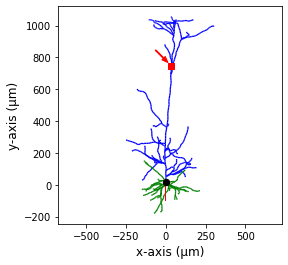

In [3]:
plot_synapse = True
cell.somaAtOrigin = False
cell.diam_scale_factor = 0
cell.diam_plus_factor  = 8
cell.pre_calc_for_plotmorph()

fig = plt.figure(figsize=(4, 4))
ax  = fig.add_subplot(111)
for i in range(1, len(cell.subsection_names)):
    idx0 = cell.eachSectionSegmentIndex[cell.eachSubsectionIndex[i][0]][0]
    idx1 = cell.eachSectionSegmentIndex[cell.eachSubsectionIndex[i][-1] - 1][-1]
    polycol = PolyCollection(list(cell.morph_zips)[idx0:idx1], edgecolors='none', facecolors=cell.subsection_colors[i])
    ax.add_collection(polycol)
if True:
    xy_soma = cell.get_section_coordinate(cell.allSectionList[0], 0.5, projection=('x', 'y'))
    ax.scatter(xy_soma[0], xy_soma[1], marker='o', s=40, color='k')
if plot_synapse == True:
    xy_synapse = cell.get_section_coordinate(cell.allSectionList[14], 1.0, projection=('x', 'y'))
    ax.scatter(xy_synapse[0], xy_synapse[1], marker='s', s=40, color='r')
    ax.arrow(x=xy_synapse[0]-100, y=xy_synapse[1]+100, dx=50, dy=-50, color='r', width=5, head_width=30, head_length=40)
    
ax.axis('equal')
ax.set_xlabel('x-axis (μm)', fontsize=12)
ax.set_ylabel('y-axis (μm)', fontsize=12)

# 2. Define synaptic input and recodings

In [4]:
'''EPSP-like current at the nexus'''
secidx = cell.allSectionNames.index('dendA1_0000000000001')
apicalIClamp = h.IClamp(cell.allSectionList[14](1))
apicalIClamp.delay  = 0.
apicalIClamp.dur    = 1e9
apicalIClamp.amp    = 0.
'''somatic input'''
somaIClamp = h.IClamp(cell.allSectionList[0](0.5))
somaIClamp.delay  = 0.
somaIClamp.dur    = 1e9
somaIClamp.amp    = 0.
'''define the recordings'''
cell.add_recordings(cell.allSectionList[0], x=0.5)
cell.add_recordings(cell.allSectionList[14], x=1.0)
cell.recordings['apicalIClamp_Iepsp'] = h.Vector().record(apicalIClamp._ref_i)
cell.recordings['apicalIClamp_Isoma'] = h.Vector().record(somaIClamp._ref_i)
cell.recordings['apicalICa'] = h.Vector().record(h.dendA1_0000000000001(1)._ref_ica)
recordingsKeysList = list(cell.recordings.keys())
print(recordingsKeysList)

['t', 'somaA(0.5)', 'dendA1_0000000000001(1.0)', 'apicalIClamp_Iepsp', 'apicalIClamp_Isoma', 'apicalICa']


In [5]:
def run_simulation_at_a_given_condition(Imax=0., Tde=20.0, Vds=0., Etheta=90, DEL=510, DUR=140, dt=0.025):
    dt       = 0.025
    tstop    = DEL + DUR + 0
    tvar     = np.arange(0, tstop, dt)
    # EF waveform
    Evar_DEL   = np.zeros_like(np.arange(0, DEL, dt))
    Evar_DUR   = Vds + np.zeros_like(np.arange(0, DUR, dt))
    Evar_tstop = np.zeros_like(np.arange(0, tstop - DEL - DUR, dt))
    Evar       = np.hstack((Evar_DEL, Evar_DUR, Evar_tstop))
    # synaptic input
    Iepsp     = - generate_epsp_like_current(taur=0.8, taud=4, imax=Imax, onset=DEL+Tde, dt=dt, tstop=tstop)
    tvar_hoc  = h.Vector().from_python(tvar)
    Iepsp_hoc = h.Vector().from_python(Iepsp)
    Iepsp_hoc.play(apicalIClamp._ref_amp, tvar_hoc, True)
    somaIClamp.delay = 0.0
    somaIClamp.dur   = 1e9
    somaIClamp.amp   = 0.0
    # run simulation 
    cell.run_simulation_EFtest(Evar=Evar, tvar=tvar, dt=dt, duration=tstop, theta=Etheta, phi=90)
    # extract the simulation results
    idx1  = 25
    idx2  = int(tstop / dt)
    t     = cell.recordings['t'].to_python()[idx1:idx2]
    vsoma = cell.recordings['somaA(0.5)'].to_python()[idx1:idx2]
    vdend = cell.recordings['dendA1_0000000000001(1.0)'].to_python()[idx1:idx2]
    Id    = cell.recordings['apicalIClamp_Iepsp'].to_python()[idx1:idx2]
    Is    = cell.recordings['apicalIClamp_Isoma'].to_python()[idx1:idx2]
    ICa   = cell.recordings['apicalICa'].to_python()[idx1:idx2]
    
    t, vsoma, vdend = np.array(t), np.array(vsoma), np.array(vdend)
    Id, Is, ICa     = np.array(Id), np.array(Is), np.array(ICa)
    return t, vsoma, vdend, Id, Is, tvar, Evar

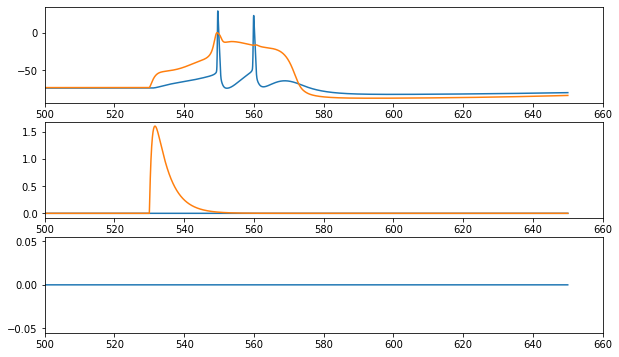

In [7]:
'''examples'''
Imax, Tde   = 1.6, 20
Vds, Etheta = 0, 90
DEL, DUR    = 510, 140
t, vsoma, vdend, Id, Is, tvar, Evar = run_simulation_at_a_given_condition(
                                    Imax=Imax, Tde=Tde, Vds=Vds, Etheta=Etheta, DEL=DEL, DUR=DUR)
fig, ax = plt.subplots(3, 1, figsize=(10, 6))
ax[0].plot(t, vsoma)
ax[0].plot(t, vdend)
ax[1].plot(t, Is)
ax[1].plot(t, Id)
ax[2].plot(tvar, Evar)
for i in range(3):
    ax[i].set_xlim(500, DEL+DUR+10)

# 3. Figure 2(b)

In [13]:
%%time
list_Vds = [-5, 0, 5]
list_vsoma, list_vdend, list_ICa = [], [], []
list_Evar = []
for amp_dc in list_Vds:
    dt       = 0.025
    DEL, DUR = 510, 150-10
    tstop    = DEL + DUR + 0
    tvar     = np.arange(0, tstop, dt)
    # electric field
    AMP_AC, FREQ = 0., 10
    AMP_DC       = amp_dc
    Evar_DEL     = np.zeros_like(np.arange(0, DEL, dt))
    Evar_DUR     = AMP_DC + AMP_AC*np.sin(2*np.pi*FREQ*np.arange(0, DUR, dt)/1000)
    Evar_tstop   = np.zeros_like(np.arange(0, tstop - DEL - DUR, dt))
    Evar         = np.hstack((Evar_DEL, Evar_DUR, Evar_tstop))
    list_Evar.append(Evar)
    # synaptic input
    Iepsp     = - generate_epsp_like_current(taur=0.8, taud=4, imax=1.6, onset=530, dt=dt, tstop=tstop)
    tvar_hoc  = h.Vector().from_python(tvar)
    Iepsp_hoc = h.Vector().from_python(Iepsp)
    Iepsp_hoc.play(apicalIClamp._ref_amp, tvar_hoc, True)   
    somaIClamp.delay  = 0.
    somaIClamp.dur    = 1e9
    somaIClamp.amp    = 0.
    # run simulation
    cell.run_simulation_EFtest(Evar=Evar, tvar=tvar, dt=dt, duration=tstop, theta=90, phi=90)
    idx1 = 25
    idx2 = int(tstop/dt)
    t      = cell.recordings['t'].to_python()[idx1:idx2]
    vsoma  = cell.recordings['somaA(0.5)'].to_python()[idx1:idx2]
    vdend  = cell.recordings['dendA1_0000000000001(1.0)'].to_python()[idx1:idx2]
    Id     = cell.recordings['apicalIClamp_Iepsp'].to_python()[idx1:idx2]
    Is     = cell.recordings['apicalIClamp_Isoma'].to_python()[idx1:idx2]
    t, vsoma, vdend = np.array(t), np.array(vsoma), np.array(vdend)
    Id, Is, ICa     = np.array(Id), np.array(Is), np.array(ICa)
    list_vsoma.append(vsoma)
    list_vdend.append(vdend)
    list_ICa.append(ICa)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(parent_dir, 'data')
# save data
np.savez(os.path.join(data_dir, 'Schaefer_vsvd_E5mVmm_tde20ms.npz'), t=t, vsoma=list_vsoma, vdend=list_vdend, Iepsp=Id, Evar=list_Evar, tvar=tvar)

Wall time: 18.5 s


Text(0.5, 0, 'Time (ms)')

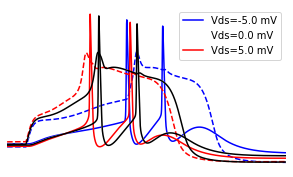

In [15]:
colorLength = 3
list_color0 = plt.get_cmap('bwr', lut=colorLength)  # seismic, cool
colors = [list_color0(i) for i in range(colorLength)]

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
for i in range(colorLength): 
    ax.plot(t, list_vsoma[i], color=colors[i], label='Vds=%.1f mV' % list_Vds[i])
    ax.plot(t, list_vdend[i], color=colors[i], ls='--')
ax.plot(t, list_vsoma[int(colorLength/2)], color='k')
ax.plot(t, list_vdend[int(colorLength/2)], color='k')
ax.set_xlim(525, 600)
ax.axis('off')
ax.legend(fontsize=10)

ax.set_ylabel('Voltages (mV)', fontsize=12)
ax.set_xlabel('Time (ms)', fontsize=12)

# 4. Figure 2(c)

In [18]:
dt       = 0.025
DEL, DUR = 520, 100
tstop    = DEL + DUR + 30
tvar     = np.arange(0, tstop, dt)
AMP_AC, FREQ = 0., 10
AMP_DC       = -5
Evar_DEL     = np.zeros_like(np.arange(0, DEL, dt))
Evar_DUR     = AMP_DC + AMP_AC*np.sin(2*np.pi*FREQ*np.arange(0, DUR, dt)/1000)
Evar_tstop   = np.zeros_like(np.arange(0, tstop - DEL - DUR, dt))
Evar         = np.hstack((Evar_DEL, Evar_DUR, Evar_tstop))
Iepsp     = - generate_epsp_like_current(taur=0.8, taud=4, imax=0.0, onset=530, dt=dt, tstop=tstop)
tvar_hoc  = h.Vector().from_python(tvar)
Iepsp_hoc = h.Vector().from_python(Iepsp)
Iepsp_hoc.play(apicalIClamp._ref_amp, tvar_hoc, True)   
somaIClamp.delay  = 0.
somaIClamp.dur    = 1e9
somaIClamp.amp    = 0.
cell.run_simulation_EFtest(Evar=Evar, tvar=tvar, dt=dt, duration=tstop, theta=90, phi=90)
idx1 = 25
idx2 = int(tstop/dt)
t      = cell.recordings['t'].to_python()[idx1:idx2]
vsoma  = cell.recordings['somaA(0.5)'].to_python()[idx1:idx2]
vdend  = cell.recordings['dendA1_0000000000001(1.0)'].to_python()[idx1:idx2]
Id     = cell.recordings['apicalIClamp_Iepsp'].to_python()[idx1:idx2]
Is     = cell.recordings['apicalIClamp_Isoma'].to_python()[idx1:idx2]
ICa    = cell.recordings['apicalICa'].to_python()[idx1:idx2]
t, vsoma, vdend = np.array(t), np.array(vsoma), np.array(vdend)
Id, Is, ICa     = np.array(Id), np.array(Is), np.array(ICa)

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(parent_dir, 'data')
np.savez(os.path.join(data_dir, 'NegtiveEF5mV_vs_vd.npz'), t=t, vsoma=vsoma, vdend=vdend, tvar=tvar, Evar=Evar)

Somatic membrane polarization = 0.91
Dendritic membrane polarization = -2.10


(np.float64(500.0),
 np.float64(650.0),
 np.float64(-3.355445169551735),
 np.float64(4.464348560586436))

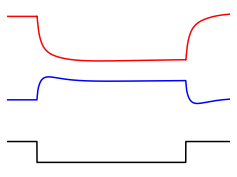

In [19]:
print('Somatic membrane polarization = %.2f' % (vsoma[4000]-vsoma[0]))
print('Dendritic membrane polarization = %.2f' % (vdend[4000]-vdend[0]))
fig, ax = plt.subplots(1,1, figsize=(4, 3))
ax.plot(t, vsoma-vsoma[0], 'b')
ax.plot(t, vdend-vdend[0] + 4, 'r')
# ax.axvline(t[4000])
ax.plot(tvar, Evar/5-2, 'k')
ax.set_xlim(500, tstop)
ax.axis('off')

In [20]:
dt       = 0.025
DEL, DUR = 520, 100
tstop    = DEL + DUR + 30
tvar     = np.arange(0, tstop, dt)
AMP_AC, FREQ = 0., 10
AMP_DC       = 5
Evar_DEL     = np.zeros_like(np.arange(0, DEL, dt))
Evar_DUR     = AMP_DC + AMP_AC*np.sin(2*np.pi*FREQ*np.arange(0, DUR, dt)/1000)
Evar_tstop   = np.zeros_like(np.arange(0, tstop - DEL - DUR, dt))
Evar         = np.hstack((Evar_DEL, Evar_DUR, Evar_tstop))
Iepsp     = - generate_epsp_like_current(taur=0.8, taud=4, imax=0.0, onset=530, dt=dt, tstop=tstop)
tvar_hoc  = h.Vector().from_python(tvar)
Iepsp_hoc = h.Vector().from_python(Iepsp)
Iepsp_hoc.play(apicalIClamp._ref_amp, tvar_hoc, True)   
somaIClamp.delay  = 0.
somaIClamp.dur    = 1e9
somaIClamp.amp    = 0.
cell.run_simulation_EFtest(Evar=Evar, tvar=tvar, dt=dt, duration=tstop, theta=90, phi=90)
idx1 = 25
idx2 = int(tstop/dt)
t      = cell.recordings['t'].to_python()[idx1:idx2]
vsoma  = cell.recordings['somaA(0.5)'].to_python()[idx1:idx2]
vdend  = cell.recordings['dendA1_0000000000001(1.0)'].to_python()[idx1:idx2]
Id     = cell.recordings['apicalIClamp_Iepsp'].to_python()[idx1:idx2]
Is     = cell.recordings['apicalIClamp_Isoma'].to_python()[idx1:idx2]
ICa    = cell.recordings['apicalICa'].to_python()[idx1:idx2]
t, vsoma, vdend = np.array(t), np.array(vsoma), np.array(vdend)
Id, Is, ICa     = np.array(Id), np.array(Is), np.array(ICa)

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(parent_dir, 'data')
np.savez(os.path.join(data_dir, 'PositiveEF5mV_vs_vd.npz'), t=t, vsoma=vsoma, vdend=vdend, tvar=tvar, Evar=Evar)

Somatic membrane polarization = -0.97
Dendritic membrane polarization = 2.00


(np.float64(500.0),
 np.float64(650.0),
 np.float64(-3.3572355172079553),
 np.float64(4.501945861367064))

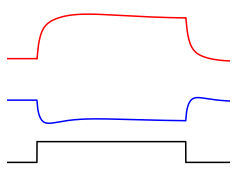

In [21]:
print('Somatic membrane polarization = %.2f' % (vsoma[4000]-vsoma[0]))
print('Dendritic membrane polarization = %.2f' % (vdend[4000]-vdend[0]))
fig, ax = plt.subplots(1,1, figsize=(4, 3))
ax.plot(t, vsoma-vsoma[0], 'b')
ax.plot(t, vdend-vdend[0] + 2, 'r')
# ax.axvline(t[4000])
ax.plot(tvar, Evar/5-3, 'k')
ax.set_xlim(500, tstop)
ax.axis('off')

# 5. Figure 5(b) inset

In [22]:
dt = 0.025
DEL, DUR = 200, 115
tstop = DEL + DUR + 0
tvar = np.arange(0, tstop, dt)

AMP_AC, FREQ = 0., 10
AMP_DC = 1
Evar_DEL = np.zeros_like(np.arange(0, DEL, dt))
Evar_DUR = AMP_DC + AMP_AC * np.sin(2 * np.pi * FREQ * np.arange(0, DUR, dt) / 1000)
Evar_tstop = np.zeros_like(np.arange(0, tstop - DEL - DUR, dt))
Evar = np.hstack((Evar_DEL, Evar_DUR, Evar_tstop))

Iepsp = - generate_epsp_like_current(taur=0.8, taud=4, imax=1, onset=250, dt=dt, tstop=tstop)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(parent_dir, 'data')
np.savez(os.path.join(data_dir, 'delta_tDE_schematic.npz'), tvar=tvar, Evar=Evar, Iepsp=Iepsp)

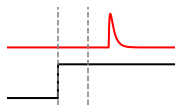

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(2*1.5, 1.2*1.5))
ax.plot(tvar, Evar, color='k', lw=2)
ax.plot(tvar, Iepsp+1.5, color='r', lw=2)
ax.set_xlim(150, tstop)
ax.set_ylim(-0.2, 2.7)
ax.axis('off')
ax.axvline(DEL, color='grey', ls='--')
ax.axvline(DEL+30, color='grey', ls='--')

# 6. Figure 6(b): polarization

In [24]:
%%time
listEfieldDirection = np.arange(-90, 270+1, 15.0)
polarization_soma = np.zeros_like(listEfieldDirection)
polarization_dend = np.zeros_like(listEfieldDirection)
for i in range(len(listEfieldDirection)):
    dt       = 0.025
    DEL, DUR = 520, 150
    tstop    = DEL + DUR
    tvar     = np.arange(0, tstop, dt)

    AMP_AC, FREQ = 0., 10
    AMP_DC       = 2.5
    Evar_DEL     = np.zeros_like(np.arange(0, DEL, dt))
    Evar_DUR     = AMP_DC + AMP_AC*np.sin(2*np.pi*FREQ*np.arange(0, DUR, dt)/1000)
    Evar_tstop   = np.zeros_like(np.arange(0, tstop - DEL - DUR, dt))
    Evar         = np.hstack((Evar_DEL, Evar_DUR, Evar_tstop))

    Iepsp     = - generate_epsp_like_current(taur=0.8, taud=4, imax=0.0, onset=530, dt=dt, tstop=tstop)
    tvar_hoc  = h.Vector().from_python(tvar)
    Iepsp_hoc = h.Vector().from_python(Iepsp)
    Iepsp_hoc.play(apicalIClamp._ref_amp, tvar_hoc, True)   
    somaIClamp.delay  = 0.
    somaIClamp.dur    = 1e9
    somaIClamp.amp    = 0.

    cell.run_simulation_EFtest(Evar=Evar, tvar=tvar, dt=dt, duration=tstop, theta=listEfieldDirection[i], phi=90)
    idx1 = 25
    idx2 = int(tstop/dt)
    t      = cell.recordings['t'].to_python()[idx1:idx2]
    vsoma  = cell.recordings['somaA(0.5)'].to_python()[idx1:idx2]
    vdend  = cell.recordings['dendA1_0000000000001(1.0)'].to_python()[idx1:idx2]
    Id     = cell.recordings['apicalIClamp_Iepsp'].to_python()[idx1:idx2]
    Is     = cell.recordings['apicalIClamp_Isoma'].to_python()[idx1:idx2]
    ICa    = cell.recordings['apicalICa'].to_python()[idx1:idx2]

    t, vsoma, vdend = np.array(t), np.array(vsoma), np.array(vdend)
    Id, Is, ICa     = np.array(Id), np.array(Is), np.array(ICa)

    polarization_soma[i] = vsoma[-1] - vsoma[0]
    polarization_dend[i] = vdend[-1] - vdend[0]
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(parent_dir, 'data')
np.savez(os.path.join(data_dir, 'polarizaiton_E2.5mV_soma_and_dend.npz'), polarization_soma=polarization_soma, polarization_dend=polarization_dend, listEfieldDirection=listEfieldDirection)

Wall time: 2min 57s
